<a href="https://colab.research.google.com/github/stefanziog/Quantized-Deep-Neural-Networks/blob/main/tf_flower_float16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import PIL
import glob
from keras.datasets import cifar10
tf.float16

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def load_dataset():
# load dataset
  dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
  data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
  data_dir = pathlib.Path(data_dir)

  image_count = len(list(data_dir.glob('*/*.jpg')))
  print(image_count)
  roses = list(data_dir.glob('roses/*'))
  PIL.Image.open(str(roses[0]))

  categories = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]



  daisy = list(data_dir.glob('daisy/*'))
  dandelion = list(data_dir.glob('dandelion/*'))
  roses = list(data_dir.glob('roses/*'))
  sunflowers = list(data_dir.glob('sunflowers/*'))
  tulips = list(data_dir.glob('turlips/*'))

  data = []
  labels = []

  for i in daisy:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size =  (280,280))
    image=np.array(image)
    data.append(image)
    labels.append(0)
  for i in dandelion:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (280,280))
    image=np.array(image)
    data.append(image)
    labels.append(1)
  for i in roses:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (280,280))
    image=np.array(image)
    data.append(image)
    labels.append(2)
  for i in sunflowers:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (280,280))
    image=np.array(image)
    data.append(image)
    labels.append(3)
  for i in tulips:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (280,280))
    image=np.array(image)
    data.append(image)
    labels.append(3)
  data = np.array(data)
  labels = np.array(labels)

  from sklearn.model_selection import train_test_split
  train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)
	
  return train_images, train_labels, test_images, test_labels

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
#EVALUATE MODEL
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [ ]:
# load dataset
train_images, train_labels, test_images, test_labels = load_dataset()

# prepare pixel data
train_images, test_images = prep_pixels(train_images, test_images)

#load model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Διπλωματική Κώδικες τελικοί/saved_models/tf_flower.h5')

228827136/228813984 [==============================] - 2s 0us/step
3670


In [ ]:
# Convert to a Tensorflow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp0jp7_hlg/assets


In [ ]:
tflite_models_dir = pathlib.Path("/tmp/flower_f16_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
tflite_model_file = tflite_models_dir/"flower_f16_model.tflite"
tflite_model_file.write_bytes(tflite_model)

10771216

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [ ]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"flower_f16_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmppn9sr09b/assets


INFO:tensorflow:Assets written to: /tmp/tmppn9sr09b/assets


5389568

In [ ]:
#LOAD LITE MODEL
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [ ]:
#TEST LITE MODEL ON IMAGE
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

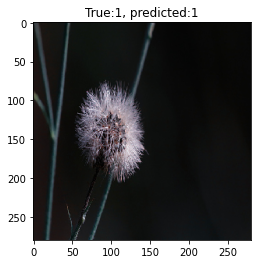

In [ ]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [ ]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictions = interpreter_fp16.get_tensor(output_index)

In [ ]:
print(evaluate_model(interpreter))
# NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite
# doesn't have super optimized server CPU kernels. For this reason this may be
# slower than the above float interpreter. But for mobile CPUs, considerable
# speedup can be observed.
print(evaluate_model(interpreter_fp16))

0.768695652173913
0.768695652173913
